<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/lab_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import random

from google.colab import userdata

!pip install pytorch-msssim -q
from pytorch_msssim import ms_ssim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [2]:

!pip install -q kornia
import kornia
import skimage


# 1. Set up project in runtime
Create colab secrets for the following credentials for the repo to get runtime files and clone repo

In [3]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/StuartLiv/CPSC-440-Project
%pwd

fatal: destination path 'CPSC-440-Project' already exists and is not an empty directory.


'/content'

# 2. Preprocess data

Datasets:
- `medset_multisize`
  - Single datasets. Dataset construction code in repo too
  - 12000 Images, in randomized order
  - Res 256x256 (grayscale images also available in 128x128, 64x64, 32x32)


Load datasets, partition sets, and make tensors in color-layer order for convolutions



In [4]:
def make_image_arr(path,cut=None,end=False):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  if end:
    files.reverse()
  if cut is not None:
    files = files[:cut]

  arr = []
  for i in tqdm(files):
    img = load_img(path + '/'+i)
    arr.append(img_to_array(img) / 255)

  return np.array(arr)

rgb_np = make_image_arr('/content/CPSC-440-Project/datasets/medset_multisize/color',cut=2400,end=True)
lab_np = skimage.color.rgb2lab(rgb_np)
color = torch.from_numpy(np.moveaxis(lab_np, [3,1], [1,2]))

def make_gray_tensor(path):
  graynp = make_image_arr(path,cut=2400,end=True)

  # take one axis
  graynp = np.moveaxis(graynp, [3,1], [1,2])

  # convert to LAB scale
  graynp = graynp[:, 0:1, :, :] * 100

  return torch.from_numpy(graynp)

gray032 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray32')
gray064 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray64')
gray128 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray128')
gray256 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray')


100%|██████████| 2400/2400 [00:05<00:00, 452.16it/s]


In [10]:
print(gray032.shape)

torch.Size([100, 1, 32, 32])


# 3. Model
Model generated below:

In [5]:
class Autoencoder(nn.Module):
    def __init__(self,intype):
        super(Autoencoder, self).__init__()
        # Encoder
        if intype == 'gray032':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
          )
        elif intype == 'gray064':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        elif intype == 'gray128':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        elif intype == 'gray256':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
          )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 3, 3, padding=1),
            #nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the emergent superesolutions autoencoders
esure032 = Autoencoder('gray032')
esure064 = Autoencoder('gray064')
esure128 = Autoencoder('gray128')
esure256 = Autoencoder('gray256')


Load stored decoder from full size model training, and fix decoder parameters.

In [6]:

esure032.encoder = torch.load('/content/CPSC-440-Project/models/old models/lab_mle_encoder_32',map_location=device)
esure064.encoder = torch.load('/content/CPSC-440-Project/models/old models/lab_mle_encoder_64',map_location=device)
esure128.encoder = torch.load('/content/CPSC-440-Project/models/old models/lab_mle_encoder_128',map_location=device)
esure256.encoder = torch.load('/content/CPSC-440-Project/models/old models/lab_mle_encoder',map_location=device)


esures = [esure032,
          esure064,
          esure128,
          esure256,
          ]

for esure in esures:
  esure.decoder = torch.load('/content/CPSC-440-Project/models/old models/lab_mle_decoder',map_location=device)

# LAB evaluation

In [7]:
inputs = [gray032, gray064, gray128, gray256]
dim_labels = [32,64,128,256]

outputs = []

with torch.no_grad():
  for i in range(4):
    esures[i].eval()
    esures[i].to(device)
    output = []

    #Necessary due to GPU SIZE Restrictions on L4 (Maybe not A100?)
    output.append(esures[i](inputs[i][:len(color)//2].to(device)).cpu())
    torch.cuda.empty_cache()

    output.append(esures[i](inputs[i][len(color)//2:].to(device)).cpu())
    outputs.append(torch.cat(output))
    torch.cuda.empty_cache()

output = torch.stack(outputs)

In [8]:
from skimage.color import rgb2lab, lab2rgb

def to_lab_tensor(input):
  arr = []
  for i in range(input.shape[0]):
    arr.append(rgb2lab(input[i].detach().numpy(), channel_axis=0))
  return torch.from_numpy(np.array(arr))

In [9]:
color_diffs = []
for i in range(4):
  color_diffs.append(ms_ssim(output[i], color, data_range = 1, size_average=False))

color_diffs = torch.stack(color_diffs)

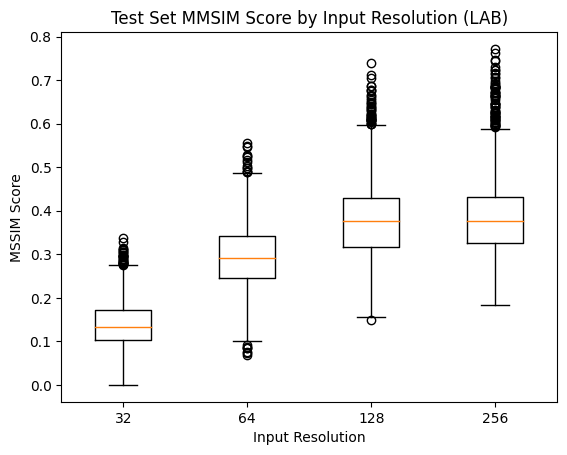

In [10]:
plt.boxplot(np.transpose(color_diffs.numpy()),
            labels = dim_labels)
            #xlabel = "MSSIM Score",
            #ylabel = "Input Resolution")
plt.ylabel("MSSIM Score")
plt.xlabel("Input Resolution")
plt.title("Test Set MMSIM Score by Input Resolution (LAB)")

plt.show()

In [11]:
color_input_diffs = []

for i in range(4):
  upscaled = f.interpolate(inputs[i].reshape(len(color),1,dim_labels[i],dim_labels[i]),size=[256,256]).repeat(1, 3, 1, 1)
  color_input_diffs.append(ms_ssim(upscaled, color, data_range = 1, size_average=False))

color_input_diffs = torch.stack(color_input_diffs)

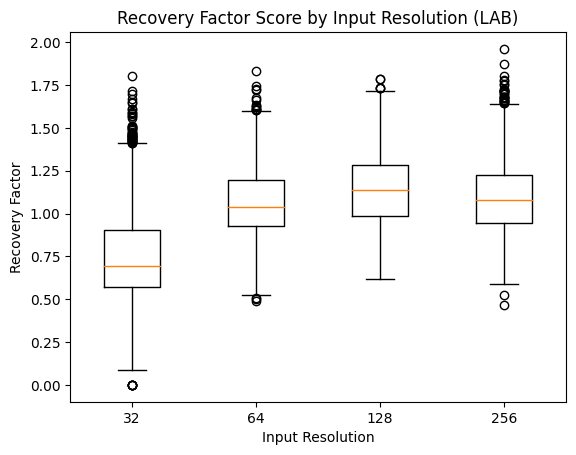

In [12]:
recovery_factor = torch.div(color_diffs, color_input_diffs)

plt.boxplot(np.transpose(recovery_factor.numpy()),
            labels = dim_labels)
            #xlabel = "MSSIM Score",
            #ylabel = "Input Resolution")
plt.ylabel("Recovery Factor")
plt.xlabel("Input Resolution")
plt.title("Recovery Factor Score by Input Resolution (LAB)")

plt.show()

In [ ]:
dim_labels = [32,64,128,256]
bw_input_diffs = []

#In theory b/w images unaffected by switch to LAB?

for i in range(4):
  upscaled = f.interpolate(inputs[i].reshape(len(color),1,dim_labels[i],dim_labels[i]),size=[256,256])
  bw_input_diffs.append(ms_ssim(upscaled, gray256, data_range = 1, size_average=False))

bw_input_diffs = torch.stack(bw_input_diffs)

bw_output_diffs = []

for i in range(4):
  bw_outputs = torch.mean(outputs[i], dim=1, keepdim=True)
  bw_output_diffs.append(ms_ssim(bw_outputs, gray256, data_range = 1, size_average=False))

bw_output_diffs = torch.stack(bw_output_diffs)


In [ ]:
plt.boxplot(np.transpose(bw_output_diffs.numpy()),
            labels = dim_labels)
            #xlabel = "MSSIM Score",
            #ylabel = "Input Resolution")
plt.ylabel("MSSIM Score")
plt.xlabel("Input Resolution")
plt.title("Grayscale MMSIM Score by Input Resolution (RGB)")

plt.show()

In [ ]:
bw_recovery_factor = torch.div(bw_output_diffs, bw_input_diffs)

plt.boxplot(np.transpose(bw_recovery_factor.numpy()),
            labels = dim_labels)
            #xlabel = "MSSIM Score",
            #ylabel = "Input Resolution")
plt.ylabel("Recovery Factor")
plt.xlabel("Input Resolution")
plt.title("Grayscale Recovery Factor Score by Input Resolution (RGB)")

plt.show()

In [ ]:
bw_sub_color = torch.sub(bw_output_diffs, color_diffs)

plt.boxplot(np.transpose(bw_sub_color.numpy()),
            labels = dim_labels)
            #xlabel = "MSSIM Score",
            #ylabel = "Input Resolution")
plt.ylabel("MSSIM Difference")
plt.xlabel("Input Resolution")
plt.title("Test Set BW MSSIM Score minus Color score (RGB)")

plt.show()

In [ ]:
recovery_factor = torch.div(color_diffs, bw_input_diffs)

plt.boxplot(np.transpose(bw_recovery_factor.numpy()),
            labels = dim_labels)
            #xlabel = "MSSIM Score",
            #ylabel = "Input Resolution")
plt.ylabel("Recovery Factor")
plt.xlabel("Input Resolution")
plt.title("Grayscale Recovery Factor Score by Input Resolution (RGB)")

plt.show()